<a href="https://colab.research.google.com/github/zum-m/01_jouhougakugairon/blob/quantium/Copy_of_%E6%BC%94%E7%BF%92%E7%AC%AC9%E5%9B%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **9.量子位相推定**

量子位相推定は、量子コンピューティングにおける重要なサブルーチンであり、
多くの量子アルゴリズムの構成要素として機能します。




##**9.1 演習のための準備**
以下のコードを実行し、qiskitをインストールしましょう。

In [ ]:
!pip install qiskit==0.39.4

さらに以下のコードを実行して、Qiskitによる学習を支援するライブラリーqiskit-textbookと量子回路を描画するためのライブラリーpylatexencもインストールします。

In [ ]:
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

In [21]:
!pip install pylatexenc

演習で使用するパッケージをqiskitライブラリーからimportします。  
以下のコードを実行しましょう。  


In [22]:
# initialization
import matplotlib.pyplot as plt
import numpy as np
import math

from numpy import pi
# importing Qiskit
from qiskit import *
from qiskit import Aer
from qiskit import BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit,execute, ClassicalRegister, QuantumRegister, assemble, transpile
from qiskit_textbook.widgets import dj_widget
from qiskit_textbook.tools import array_to_latex
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.visualization import plot_bloch_multivector



##***9.2 量子位相推定の目的と考え方***


### **9.2.1 目的**
ある$2×2$行列$U$に対し、以下の条件を満たす  
$2$次元ベクトル$|\psi⟩$が存在するとします。
$$U|\psi⟩=e^{2πi\theta}|\psi⟩$$
この条件は、ベクトル$|\psi⟩$が$U$の固有ベクトルであることを意味します。  
固有値が$e^{2πi\theta}$の形式をもつ行列$U$は「ユニタリー行列」と呼ばれます。  
$\theta$は位相と呼ばれ、その値は$0\le \theta<1$です。

量子位相推定の目的は、ユニタリー行列$U$とその固有状態$|\psi⟩$が与えられた上で  
固有値$e^{2πi\theta}$における位相$\theta$の値を推定することにあります。  
このとき$U$、$|\psi⟩$の成分は「秘密」にされます。  
つまりこれらはブラックボックスであり、私たちは内容を知ることができません。  
ただし$U$の$|\psi⟩$に対する演算自体は何回でも実行可能であるとされます。



### **9.2.2 考え方**
量子位相推定のアルゴリズムにおける主要な作業は  
$n$個の量子ビットレジスタに以下のような状態をつくり出すことです。
$$\frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{2\pi i\theta\cdot y}|y⟩$$
$N=2^n$であり、$|y⟩$はビット列$|y_1⟩\otimes |y_2⟩\otimes \cdots \otimes |y_n⟩$を意味します。  
$y$の値は$y=2^{n-1}y_1+2^{n-2}y_2+\cdots +2y_{n-1}+y_n$と定められるとします。

前回学んだ「量子フーリエ変換(QFT)」思い出してください。  
量子フーリエ変換はビット列$|x⟩=|x_1⟩⊗|x_2⟩⊗\cdots ⊗|x_n⟩$を
$$|x⟩\xrightarrow{QFT} \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{\frac{2\pi}{N} ix\cdot y}|y⟩$$
のように変換します。これと冒頭の状態を見比べてみましょう。  
冒頭の状態はあたかも、$|x⟩=|N\theta ⟩$と表せた場合の量子フーリエ変換の結果のようです。

ここで量子フーリエ変換の“逆”、「逆量子フーリエ変換」と呼ばれる変換を考えます。  
この変換は$\mathrm{QFT}^{†}$と記述され、量子フーリエ変換後の状態を元に戻す作用を意味します。
$$\frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{\frac{2\pi}{N} ix\cdot y}|y⟩\xrightarrow{QFT^{†}}|x⟩ $$
冒頭の状態に逆量子フーリエ変換($\mathrm{QFT}^{†}$)とどうなるでしょうか。
$$\frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{2\pi i\theta\cdot y}|y⟩\xrightarrow{QFT^{†}}|N\theta⟩$$
となり、最後に量子レジスタに観測をおこなえば、結果から$\theta$の値が判明することが期待できます。  
ただし注意が必要です。量子ビットレジスタが表現するのはあくまで$0$～$2^n-1$の整数値です。  
$\theta$の値は実数値なので、$N\theta=2^n\theta$が整数値になるとは限りません。  
実際には$N\theta$に近い整数値に対応したビット列が高い確率で測定されることになります。  
ここに当アルゴリズムが「推定」である理由があります。

## **9.3 量子位相推定の手順**
前節の考え方に基づく量子位相推定の手順は以下の通りです。

* **手順１:** 全てが状態$|0⟩$にある$n$ 個の量子ビットレジスタと$U$の固有状態$|\psi\rangle$にある$n+1$番目の量子ビットを用意します。
$$
|\psi_{0}⟩=|0\rangle^{\otimes n}⊗|\psi\rangle
$$

* **手順２:** $n$ 個の量子ビットレジスタにアダマールゲート$H^{⊗n}$を適用します。
$$
|\psi_{1}⟩=\frac{1}{2^{\frac{n}{2}}}(|0\rangle+|1\rangle)^{\otimes n}⊗|\psi\rangle
$$

* **手順３:** $n$量子ビットレジスタ内の$j$番目の量子ビットが$|1⟩$のときのみ、$n+1$番目の量子ビットに$U$演算を$2^{n-j}$回おこないます。  
つまり$j$番目の量子ビットを制御、$n+1$番目の量子ビットを標的とした制御ユ二タリー演算 $\mathrm{CU}$ を$2^{n-j}$回適用します。  
状態$|\psi⟩$に $U$演算を$2^{n-j}$回施すと、
$$U^{2^{n-j}}|\psi⟩=U^{2^{n-j}-1}U|\psi⟩=U^{2^{n-j}-1}e^{2\pi i\theta}|\psi⟩=\cdots =e^{2 \pi i 2^{n-j} \theta}|\psi\rangle$$
となります。$j$番目の量子ビットと$n+1$番目の量子ビットの状態$\frac{1}{\sqrt2}\left(|0⟩+|1⟩ \right)⊗|\psi⟩$は  
$\mathrm{CU}^{2~{n-j}}$ゲートの適用により以下の状態に変換されます。（位相キックバックの効果です。）  
$$\frac{1}{\sqrt2}\left(|0⟩+e^{2 \pi i 2^{n-j} \theta}|1⟩ \right)⊗|\psi⟩$$
$j=1$～$n$まで同様の変換がおこなわれます。結果、全量子ビットの状態は
$$
\begin{aligned}
|\psi_{2}⟩ &=\frac{1}{2^{\frac{n}{2}}}\left(|0\rangle+e^{2 \pi i \theta 2^{n-1}}|1\rangle\right) \otimes \cdots \otimes\left(|0\rangle+e^{2 \pi i \theta 2^{1}}|1\rangle\right) \otimes\left(|0\rangle+e^{2 \pi i \theta 2^{0}}|1\rangle\right) \otimes|\psi\rangle \\
&=\frac{1}{\sqrt N} \sum_{y=0}^{2^{n}-1} e^{2 \pi i \theta y}|y\rangle \otimes|\psi\rangle
\end{aligned}
$$
となります。

* **手順４:** $n$量子ビットレジスタに逆量子フーリエ変換($\mathrm{QFT}^{†}$)を施します。ビット列$|y⟩$に$\mathrm{QFT}^{†}$を施すと
$$\mathrm{QFT}^{†}|y⟩=\frac{1}{\sqrt N}\sum_{x=0}^{N-1}e^{-\frac{2π}{N}iyx}|x⟩$$
となることに注意してください。したがって、全量子ビットの状態は$\mathrm{QFT}^{†}$により
$$
\left|\psi_{3}\right\rangle= \sum_{x=0}^{N-1} \left[\frac{1}{N}\sum_{y=0}^{N-1} e^{\frac{2 \pi i y}{N}\left(N\theta-x \right)}\right]|x\rangle \otimes|\psi\rangle
$$
となります。

* **手順５:** $n$量子ビットレジスタに観測をおこないます。  
上式から$N\theta$に最も近い整数値$x$に対応するビット列が高い確率で観測されることが分かります。  
観測結果$x$を読み取り、$\theta$値を  
$$\theta≈\frac{x}{N}$$
と推定します。



## **9.4 量子位相推定のシミュレーション**
量子位相推定を実装した量子回路を作成し、シミュレーションをおこないます。

ユニタリー行列$U$の例として $P$行列を用います。
$$P=\left[\begin{array}{cc}
1 & 0 \\
0 & e^{2πi\theta}
\end{array}\right]$$
いわゆる$P$ゲートに対応した行列ですね。
この行列の固有状態は$|0⟩$と$|1⟩$です。  
ここでは固有値$e^{2πi\theta}$の固有状態$|1⟩$に注目しましょう。
$$P|1⟩=e^{2πi\theta}|1⟩$$
この例では$U=P$、$|\psi⟩=|1⟩$とします。  
そして秘密の$\theta$値を
$$\theta=\frac{1}{3}$$
としておきましょう。この値を推定することを目的にします。

では前節の手順に従う量子回路を作成し、シミュレーションを行います。

### **9.4.1 4量子ビットでの実装**

**手順１**
４量子ビットと3出力ビットで構成される量子回路を作成します。
```
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw('mpl')
```

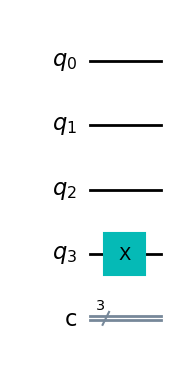

In [32]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw('mpl')

量子ビット$q_2$、$q_1$、$q_0$をそれぞれ第1、第2、第3量子ビットとし、  
初期状態は$|000⟩$とします。第4の量子ビット$q_3$の初期状態も$|0⟩$ですが、  
$X$ゲートにより$|1⟩$となります。この状態は行列$P$の固有状態$|\psi⟩$に対応します。


**手順２** $3$量子ビットレジスタにアダマールゲート$H$を適用します。
```
for qubit in range(3):
    qpe.h(qubit)
qpe.draw('mpl')
```


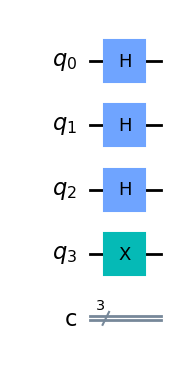

In [33]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw('mpl')

**手順３** 　$3$量子ビットレジスタ内の$j$番目の量子ビットを制御、  
$4$番目の量子ビットを標的とした制御ユ二タリーゲート $\mathrm{CP}$ を$2^{3-j}$回適用します。   
 $P$行列における$\theta$は$\frac{1}{3}$としています。
 ```
 number = 1
for qubit in range(3):
    for i in range(number):
        qpe.cp(2*math.pi/3, qubit, 3); # CPゲートを2^{3-j}回適用
    number *= 2 #numberを2倍する
qpe.draw('mpl')
```


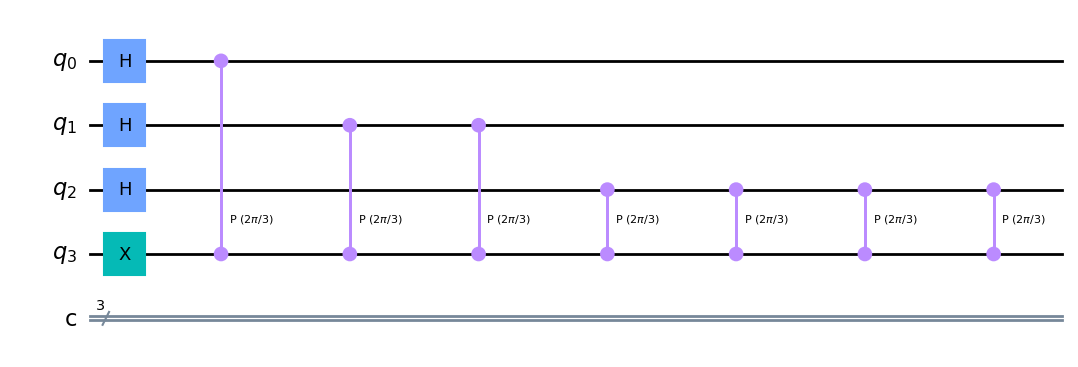

In [34]:
number = 1
for qubit in range(3):
    for i in range(number):
        qpe.cp(2*math.pi/3, qubit, 3); # CPゲートを2^{3-j}回適用
    number *= 2 #numberを2倍する
qpe.draw('mpl')

**手順４** $3$量子ビットレジスタに逆量子フーリエ変換($\mathrm{QFT}^{†}$)を施します。  
これを実行する手続きは$\mathrm{QFT}$の逆となります。

逆量子フーリエ変換($\mathrm{QFT}^{†}$)を実装した回路を作成する関数のコードは  
以下のようになります。
```
def qft_dagger(qc, n):#引数は回路(qc)とレジスタ内のビット数(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)#最初にスワップゲートを適用します。
    for j in range(n):
        for m in range(j):#CPゲートの適用（j=0のときは適用されません）
            qc.cp(-pi/2**(j-m), m, j)
        qc.h(j)#最後にアダマールゲートの適用
```


In [35]:
def qft_dagger(qc, n):#引数は回路(qc)とレジスタ内のビット数(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)#最初にスワップゲートを適用します。
    for j in range(n):
        for m in range(j):#CPゲートの適用（j=0のときは適用されません）
            qc.cp(-pi/2**(j-m), m, j)
        qc.h(j)#最後にアダマールゲートの適用

```
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
qpe.draw('mpl')
```

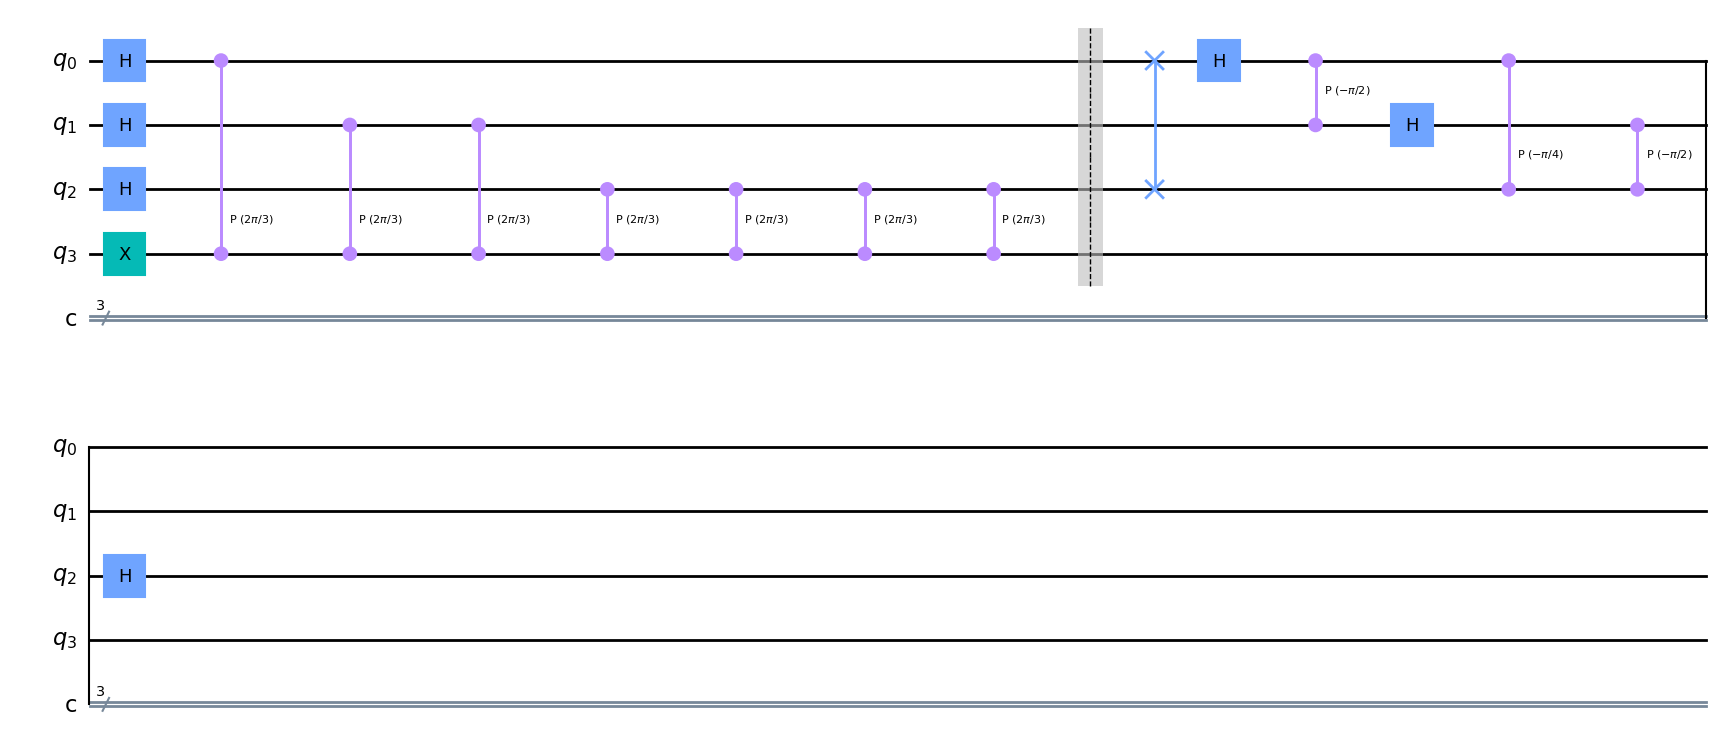

In [36]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
qpe.draw('mpl')

**手順５** $3$量子ビットレジスタに観測をおこないます。
```
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)
qpe.draw('mpl')
```  

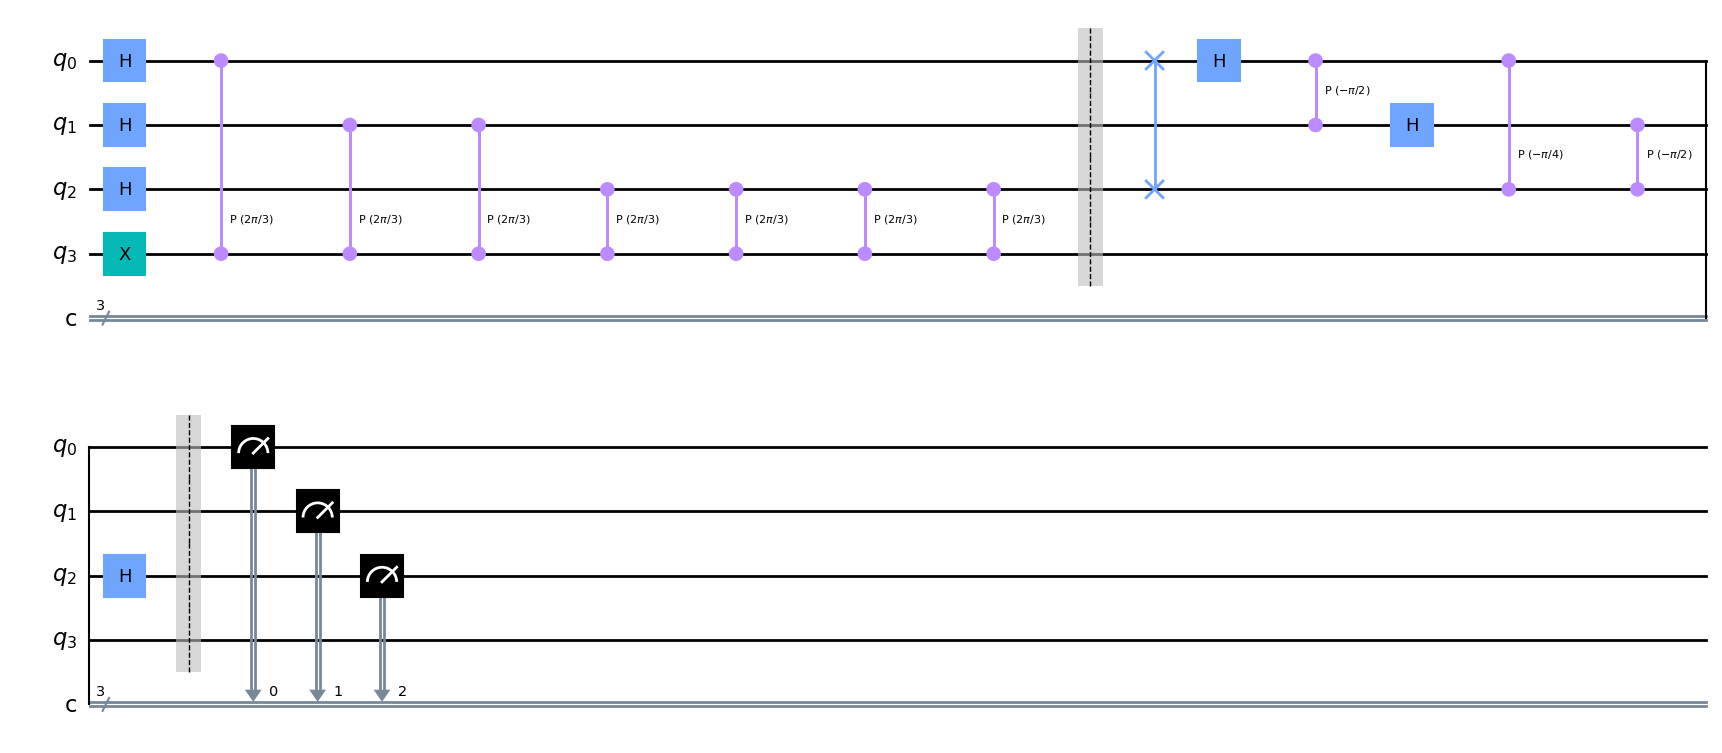

In [37]:
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)
qpe.draw('mpl')

これで完成です。

**シミュレーション**  
以下のコードによりシミュレーションをおこないます。  
$\theta×2^{3}=8/3$に最も近い整数値に対応したビット列
$011$  
が最も高い確率で観測されるはずです。
```
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)
```

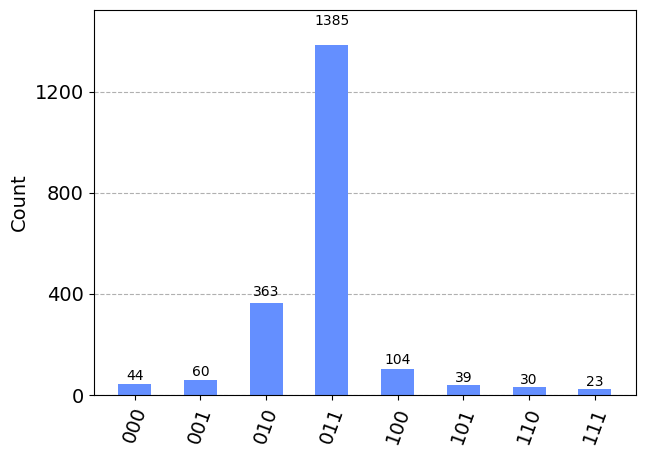

In [38]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

2番目に高い確率で得られるビット列は$010$で整数値2に対応しますね。
この結果より、$\theta$の値は「$\frac{2}{8}=0.25$ から $\frac{3}{8}≈0.375$付近」と推定されます。真の$\theta$値は$0.333\cdots$ですよね。  
かなりざっくりとした推定となります。

## **演習課題09**

###問題
9.4節の例について、より推定の精度を上げるために6量子ビット5出力の量子回路を作成し、  
シミュレーション結果を示しなさい。


**解答**

量子回路の作成



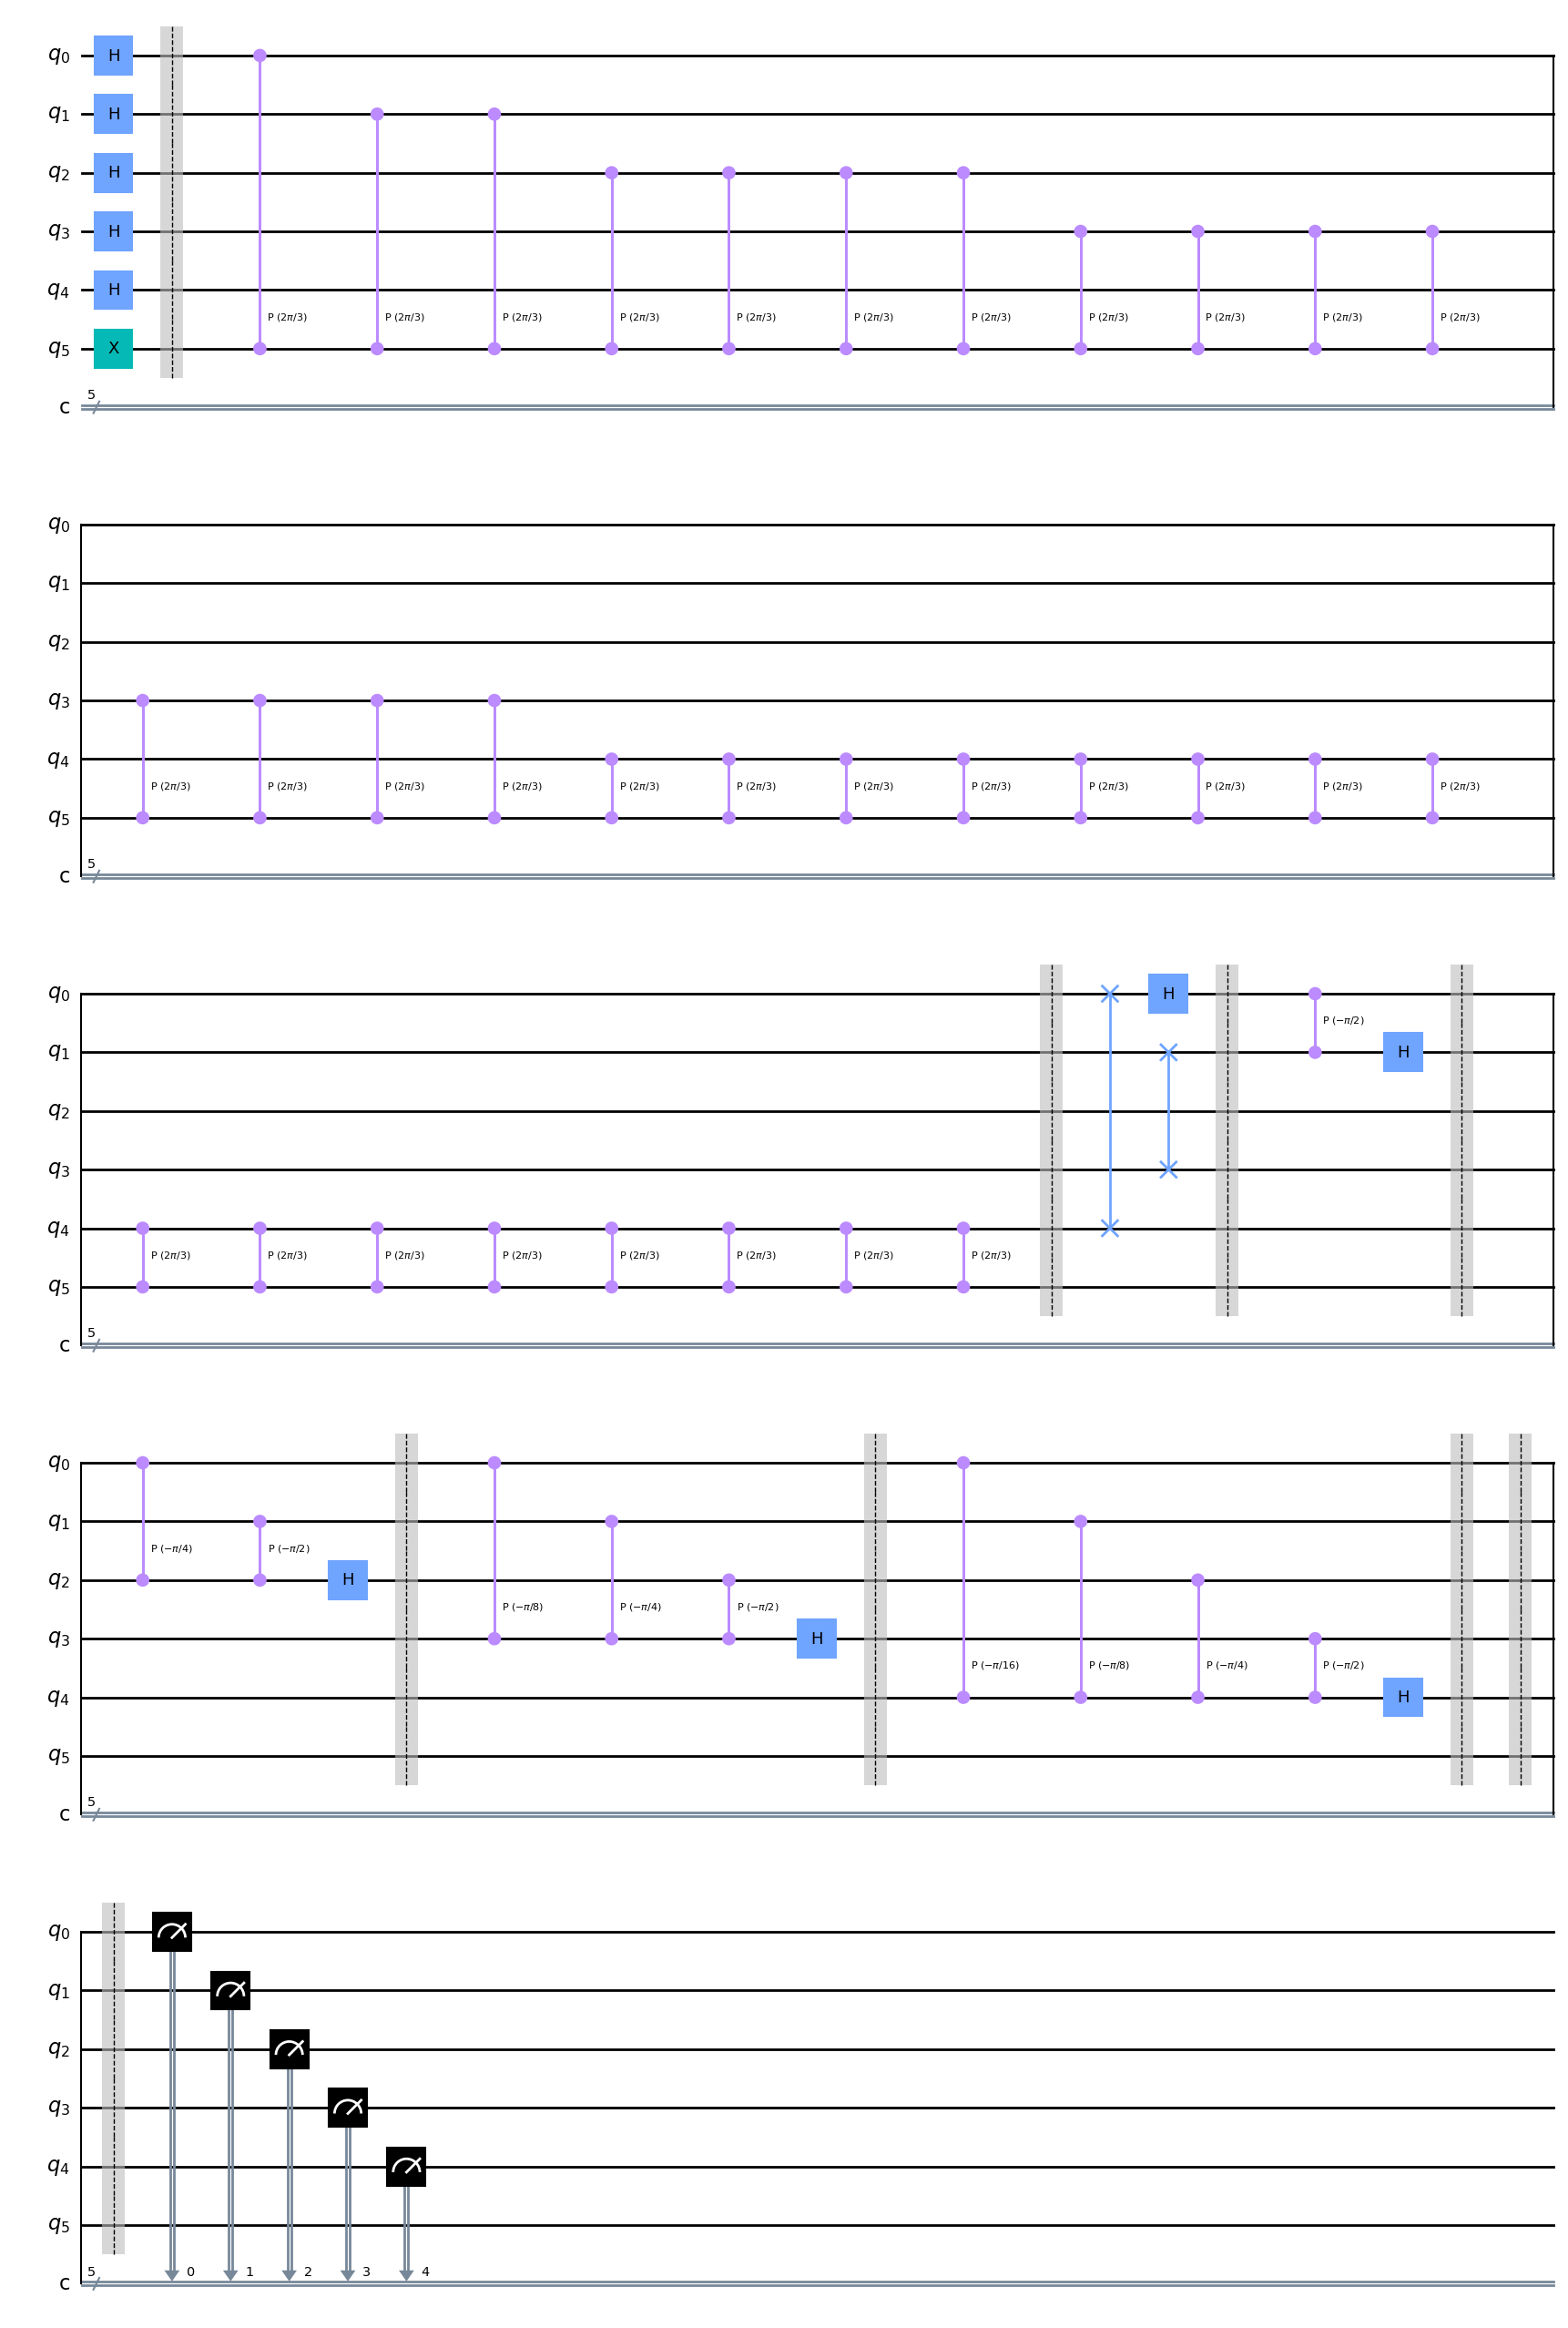

In [43]:
n = 5

qpe = QuantumCircuit(n+1, n)
qpe.x(n)
qpe.draw('mpl')


for qubit in range(n):
    qpe.h(qubit)
qpe.draw('mpl')
qpe.barrier()



number = 1
for qubit in range(n):
    for i in range(number):
        qpe.cp(2*math.pi/3, qubit, n); # CPゲートを2^{3-j}回適用
    number *= 2 #numberを2倍する

qpe.draw('mpl')
qpe.barrier()



def qft_dagger(qc, n):#引数は回路(qc)とレジスタ内のビット数(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)#最初にスワップゲートを適用します。
    for j in range(n):
        for m in range(j):#CPゲートの適用（j=0のときは適用されません）
            qc.cp(-pi/2**(j-m), m, j)
        qc.h(j)#最後にアダマールゲートの適用
        qpe.barrier()



# Apply inverse QFT
qft_dagger(qpe, n)
qpe.draw('mpl')
qpe.barrier()



# Measure
qpe.barrier()
for n in range(n):
    qpe.measure(n,n)
qpe.draw('mpl')

シミュレーション

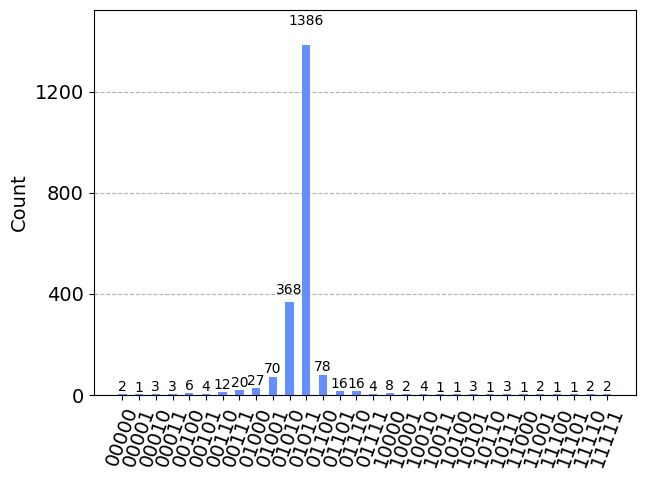

In [44]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

1,2番の高い確率で測定されるビット列は$01011$と$01010$です。  
これらは整数値$11$,$10$に対応します。
この結果より、$\theta$の値は「$\frac{10}{32}≈0.3125$から$\frac{11}{32}≈0.34375$付近」と推定されます。